In [1]:
!pip install tensorflow faiss

### Prepare the dataset

In [2]:
import numpy as np
from tensorflow import keras

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(x_train.shape)

mnist = x_train.reshape(60000, 28*28)
mnist.shape

(60000, 28, 28)


(60000, 784)

### Test the index

In [3]:
import time
import faiss

faiss.omp_set_num_threads(1)

In [4]:
d = mnist.shape[1]

m = 196
nbits = 9
PQ = faiss.IndexPQ(d, m, nbits)
print(PQ.is_trained)
PQ.train(mnist)
PQ.add(mnist)

D, I = PQ.search(mnist[40].reshape(1, mnist.shape[1]), 100)
print(I)

flat = faiss.IndexFlatL2(mnist.shape[1])
flat.add(mnist)

D, FLAT_I = flat.search(mnist[40].reshape(1, mnist.shape[1]), k=100) 
print(FLAT_I)

False
[[   40 34359 19446 17928 47434  3714 34613 50709  3604 44210 45366 57855
   3418 33992 18741 32765 49512  5530 15786 36240 37518 34426 18852  6665
    838 46984 40694  9161 20810 56559 43770 45220 23492 47440 25822 49440
  31045 39095  8166 30337 36968  2762  4772 29666 11178 49964 44158 52362
  48444 40864  9173 21379 14234 55080 16932 56192 15380 14126 34423 12436
  30209 18389  1910 26960  7060 32979  4766 20760 46507 17711 37014 37948
  35108  8602 31916 40140 22794 56980 43286 41640 54816 23396  2227 33942
  16345 56834 49876 11412 32859 44556 50842 45926  4070 53436 12952 40516
  37232 41852 38463 45693]]
[[   40 19446 34359 47434 34613 50709 17928  3604  3714  3418 44210 57855
  45366 32765  5530 49512 18741 33992 18852 15786 45220  6665   838 37518
  43770 46984  9161 49440 34426 25822 36240 20810 40694 31045  2762 23492
  47440 30337 56559  8166 29666 49964 36968 40864 39095 21379  4772 14234
  44158 55080  1910 34423 46507 11178 48444 37014 16932  9173 12436 56192
  49

In [5]:
# Calculate the recall
I = I.flatten()
FLAT_I = FLAT_I.flatten()
sum([1 for i in I if i in FLAT_I])

97

In [6]:
from faiss import write_index
write_index(PQ, 'save/PQ-b9.index')

### Benchmark

In [7]:
import time

bits = [3, 4, 5, 6, 7, 8, 9]
indexes =[]
build_time=[]

def build_index(data, n_bits, m=196):
    index = faiss.IndexPQ(data.shape[1], m, n_bits)
    index.train(data)
    index.add(data)
    return index

for n_bits in bits:
    start = time.time()
    index = build_index(mnist, n_bits=n_bits)
    btime = time.time() - start
    build_time.append(btime)
    indexes.append(index)

print(build_time)

[1.3684687614440918, 2.397388219833374, 5.909264802932739, 15.97317886352539, 47.07103371620178, 126.4401843547821, 239.72638392448425]


In [8]:
def recall(pred, true):
    return sum([1 for i in pred if i in true]) / true.size

def benchmark_knn_query(data, indexes, size=1000, k=100):
    result = []

    indices = np.random.choice(data.shape[0], size, replace=False)
    for index in indexes:
        query_time = 0
        cur_recall = 0

        # query
        for i in indices:
            start = time.time()
            D, I = index.search(data[i].reshape(1, data.shape[1]), k=k)
            query_time += (time.time() - start)
            D, FLAT_I = flat.search(data[i].reshape(1, data.shape[1]), k=k) 
            cur_recall += recall(I.flatten(), FLAT_I.flatten())
        
        result.append((query_time/1000, cur_recall/1000))

    return result

result = benchmark_knn_query(mnist, indexes) 
print(result)   

[(0.01302121353149414, 0.8378800000000003), (0.014648454189300537, 0.8845299999999954), (0.01806602168083191, 0.9159499999999968), (0.019102319240570067, 0.9354200000000032), (0.02169434690475464, 0.9505700000000104), (0.005555976867675781, 0.9622200000000142), (0.02997782278060913, 0.9703800000000139)]


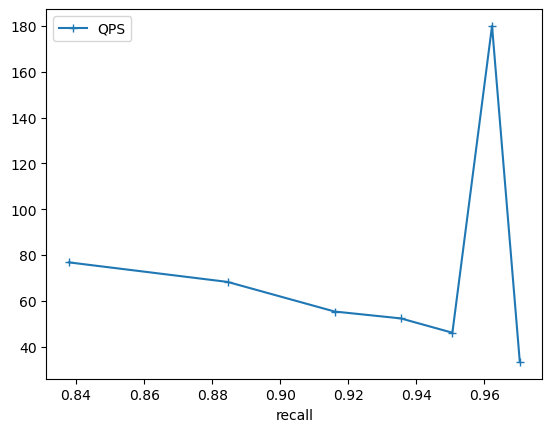

In [9]:
import pandas as pd

df = pd.DataFrame(result, columns=['query_time', 'recall'])
df['QPS'] = 1 / df['query_time']
df.plot(x='recall', y='QPS',style='+-')

import os  
os.makedirs('results', exist_ok=True)
df.to_csv('results/pq-mnist.csv')